#  Loading

`SigMea1-28` is not properly named it should be `SigMea1-H28`, rename it before running the rest of this code !
`sigDiaA-H34.txt` age was set at 50 but in all other tasks it was set at 40 so I set it to 40, do it as well before running the rest of the code ! See :  
circA-H34.txt 40 circB-H34.txt 40 sigDiaB-H34.txt 40 sigMea1-H34.txt 40 sigMea2-H34.txt 40 sigMea3-H34.txt 40 sigMea4-H34.txt 40 sigSp1-H34.txt 40 sigSp2-H34.txt 40 sigSp3-H34.txt 40 sigSp4-H34.txt 40 

In [180]:
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
from utils import flat_list
import warnings
from load_data import massage_data
from utils import return_metrics

In [181]:
index2measure=["CH1: Microphone",
"CH 2: Fingergrip",
"CH 3: Axial Pressure of ink Refill",
"CH 4: Tilt and Acceleration in X direction",
"CH 5: Tilt and Acceleration in Y direction",
"CH 6: Tilt and Acceleration Z direction"]

In [193]:
data_path=join("..","NewHandPD","Healthy","Signal","Signal")
task_path=listdir(data_path)
task_path.sort()

In [189]:
def load_NewHandPD(group,data,ages,load_task):
    data_path=join("..","NewHandPD",group,"Signal","Signal")
    task_path=listdir(data_path)
    task_path.sort()
    counter=0
    for task in task_path:
        
        task_name=''.join(i for i in task.split("-")[0])
        if task_name == load_task:
            path=join(data_path,task)
            with open(path) as file:
                raw_line=file.readlines()[2]
                age=int(''.join(i for i in raw_line if i.isdigit()))
                ages.append(age)
            data.append(np.loadtxt(path, dtype=float, skiprows=17,delimiter="\t"))
            counter+=1
    if group == "Patients":
        assert counter==31
    else:
        assert counter==35

In [210]:
np.mean(np.asarray(ages),axis=0)

array([56.        , 61.        , 58.        , 57.        , 48.        ,
       61.        , 55.        , 64.        , 55.        , 43.        ,
       62.        , 59.        , 56.        , 58.        , 78.        ,
       55.        , 65.        , 59.        , 59.        , 49.        ,
       63.        , 62.        , 38.        , 52.        , 53.        ,
       64.        , 56.        , 65.        , 67.        , 60.        ,
       61.        , 58.        , 56.        , 56.        , 25.        ,
       30.        , 26.        , 42.        , 51.        , 50.        ,
       57.        , 60.        , 41.        , 34.        , 46.        ,
       24.        , 34.        , 59.        , 21.        , 52.        ,
       50.        , 56.        , 22.        , 64.        , 14.        ,
       61.        , 40.83333333, 19.        , 40.        , 41.        ,
       45.        , 24.        , 79.        , 41.        , 44.        ,
       55.        ])

In [212]:
task_names=["circA","circB","sigDiaA","sigDiaB","sigMea1","sigMea2","sigMea3","sigMea4","sigSp1","sigSp2","sigSp3","sigSp4"]


data=[]
load_task=task_names[:]
n_tasks=len(load_task)
ages=[]

warnings.warn("You should first load Patients then Healthy, else your targets will be wrong !")

for task_name in load_task:
    task=[]
    task_age=[]
    load_NewHandPD("Patients",task,task_age,task_name)
    load_NewHandPD("Healthy",task,task_age,task_name)
    ages.append(task_age)
    data.append(task)
targets=[1 for _ in range(31)]+[0 for _ in range(35)]
lengths=[[len(subject) for subject in task]for task in data]

subject_ages=np.mean(ages,axis=0)
subjects_lengths=np.mean(lengths,axis=0)
spiral_lengths=lengths[-4:]
meanders_lengths=lengths[-8:-4]
flat_ages=np.asarray(ages).T.reshape(-1)
flat_lengths=np.asarray(lengths).T.reshape(-1)
print(len(data),len(data[0]),len(targets),load_task)

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: You should first load Patients then Healthy, else your targets will be wrong !
  if __name__ == '__main__':


12 66 66 ['circA', 'circB', 'sigDiaA', 'sigDiaB', 'sigMea1', 'sigMea2', 'sigMea3', 'sigMea4', 'sigSp1', 'sigSp2', 'sigSp3', 'sigSp4']


# Confusion Matrix



In [427]:
median=np.median(subjects_lengths)

In [296]:
def rule_based(threshold,subjects_lengths=subjects_lengths):
    tp=len([i for i in subjects_lengths[:31] if i >threshold])
    fp=31-tp

    tn=len([i for i in subjects_lengths[31:] if i <=threshold])
    fn=35-tn
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    results=""
    for metric in [accuracy,sensitivity,specificity,ppv,npv]:
        results+=" | {:.2f}".format(metric)
    print(results)

In [297]:
for i,task in enumerate(task_names):
    print(task,end="")
    rule_based(np.median(lengths[i]),lengths[i])

circA | 0.88 | 0.85 | 0.91 | 0.90 | 0.86
circB | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaA | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaB | 0.76 | 0.74 | 0.77 | 0.74 | 0.77
sigMea1 | 0.85 | 0.82 | 0.88 | 0.87 | 0.83
sigMea2 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea3 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea4 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp1 | 0.80 | 0.78 | 0.82 | 0.81 | 0.80
sigSp2 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp3 | 0.86 | 0.84 | 0.88 | 0.87 | 0.86
sigSp4 | 0.76 | 0.73 | 0.79 | 0.77 | 0.74


In [293]:
rule_based(np.median(np.mean(meanders_lengths,axis=0)),np.mean(meanders_lengths,axis=0))

 | 0.85 | 0.82 | 0.88 | 0.87 | 0.83


# 10-CV
## when setting threshold at median(subjects_lengths)



task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
circA | 0.88 | 0.85 | 0.91 | 0.90 | 0.86
circB | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaA | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaB | 0.76 | 0.74 | 0.77 | 0.74 | 0.77
sigMea1 | 0.85 | 0.82 | 0.88 | 0.87 | 0.83
sigMea2 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea3 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea4 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp1 | 0.80 | 0.78 | 0.82 | 0.81 | 0.80
sigSp2 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp3 | 0.86 | 0.84 | 0.88 | 0.87 | 0.86
sigSp4 | 0.76 | 0.73 | 0.79 | 0.77 | 0.74
sigMea_mean  | 0.85 | 0.82 | 0.88 | 0.87 | 0.83
sigSp_mean| 0.82 | 0.79 | 0.85 | 0.84 | 0.80
early fusion| 0.85 | 0.82 | 0.88 | 0.87 | 0.83

## With Linear discriminant analysis (see below)
### using exam duration

task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
circA | 0.79 ± (0.17) | 0.63 ± (0.31) | 0.94 ± (0.12) | 0.82 ± (0.32) | 0.77 ± (0.18) | 
circB | 0.81 ± (0.14) | 0.70 ± (0.23) | 0.92 ± (0.13) | 0.89 ± (0.18) | 0.79 ± (0.16) | 
sigDiaA | 0.76 ± (0.14) | 0.71 ± (0.23) | 0.80 ± (0.23) | 0.81 ± (0.21) | 0.78 ± (0.17) | 
sigDiaB | 0.78 ± (0.12) | 0.69 ± (0.29) | 0.86 ± (0.18) | 0.86 ± (0.18) | 0.81 ± (0.17) | 
sigMea1 | 0.88 ± (0.11) | 0.82 ± (0.24) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.88 ± (0.15) | 
sigMea2 | 0.82 ± (0.14) | 0.69 ± (0.33) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.82 ± (0.19) | 
sigMea3 | 0.82 ± (0.12) | 0.69 ± (0.29) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.81 ± (0.17) | 
sigMea4 | 0.79 ± (0.11) | 0.62 ± (0.29) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.77 ± (0.16) | 
sigSp1 | 0.81 ± (0.13) | 0.69 ± (0.25) | 0.92 ± (0.17) | 0.93 ± (0.15) | 0.79 ± (0.15) | 
sigSp2 | 0.80 ± (0.11) | 0.62 ± (0.25) | 0.97 ± (0.07) | 0.97 ± (0.07) | 0.76 ± (0.14) | 
sigSp3 | 0.82 ± (0.12) | 0.72 ± (0.26) | 0.91 ± (0.14) | 0.92 ± (0.13) | 0.81 ± (0.17) | 
sigSp4 | 0.83 ± (0.11) | 0.69 ± (0.25) | 0.97 ± (0.07) | 0.97 ± (0.07) | 0.80 ± (0.15) | 
sigMea_mean | 0.80 ± (0.13) | 0.66 ± (0.31) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.79 ± (0.18) | 
sigSp_mean| 0.82 ± (0.12) | 0.69 ± (0.25) | 0.94 ± (0.12) | 0.94 ± (0.12) | 0.79 ± (0.15) | 
early fusion | 0.85 ± (0.12) | 0.79 ± (0.24) | 0.92 ± (0.17) | 0.93 ± (0.13) | 0.86 ± (0.15) | 

### using subject's age
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
0.74 ± (0.12) | 0.85 ± (0.19) | 0.64 ± (0.29) | 0.73 ± (0.17) | 0.78 ± (0.30) | 

### using both
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
0.83 ± (0.14) | 0.76 ± (0.28) | 0.91 ± (0.14) | 0.92 ± (0.13) | 0.84 ± (0.17) | 


# 15 runs of 50-50 split

task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
circA | 80.61 ± (4.40) | 66.94 ± (7.68) | 92.77 ± (5.39) | 89.62 ± (7.19) | 76.13 ± (4.48) | 
circB | 83.43 ± (4.68) | 74.67 ± (11.49) | 91.22 ± (6.67) | 89.27 ± (7.05) | 80.96 ± (6.84) | 
sigDiaA | 75.96 ± (5.90) | 69.36 ± (14.56) | 82.11 ± (9.31) | 79.06 ± (9.93) | 76.04 ± (8.80) | 
sigDiaB | 77.17 ± (5.52) | 68.64 ± (11.77) | 84.84 ± (9.71) | 81.50 ± (9.94) | 75.93 ± (6.52) | 
sigMea1 | 86.67 ± (4.67) | 77.14 ± (9.00) | 95.08 ± (4.13) | 93.35 ± (5.41) | 82.84 ± (5.38) | 
sigMea2 | 81.82 ± (3.67) | 68.69 ± (10.18) | 93.59 ± (5.40) | 91.17 ± (7.05) | 77.57 ± (5.44) | 
sigMea3 | 82.02 ± (3.22) | 67.36 ± (5.95) | 95.08 ± (4.13) | 92.64 ± (5.94) | 76.75 ± (3.41) | 
sigMea4 | 79.60 ± (3.40) | 62.22 ± (6.61) | 95.08 ± (4.13) | 92.09 ± (6.57) | 74.02 ± (3.35) | 
sigSp1 | 75.96 ± (6.40) | 60.11 ± (14.42) | 90.13 ± (6.44) | 84.90 ± (9.24) | 72.59 ± (7.54) | 
sigSp2 | 79.80 ± (5.50) | 61.39 ± (11.70) | 96.25 ± (4.85) | 93.91 ± (7.28) | 74.12 ± (5.40) | 
sigSp3 | 82.22 ± (3.48) | 70.78 ± (7.84) | 92.42 ± (4.97) | 89.61 ± (6.42) | 78.38 ± (4.42) | 
sigSp4 | 83.03 ± (2.66) | 69.08 ± (7.11) | 95.45 ± (5.27) | 93.74 ± (6.32) | 77.92 ± (3.92)
meanders|81.82 ± (3.13) | 66.89 ± (6.45) | 95.08 ± (4.13) | 92.60 ± (5.85) | 76.53 ± (3.12) | 
spirals| 82.02 ± (3.02) | 68.69 ± (8.17) | 93.94 ± (5.34) | 91.68 ± (6.64) | 77.47 ± (4.45) | 
all|83.84 ± (3.26) | 74.61 ± (8.11) | 92.03 ± (5.44) | 89.80 ± (6.35) | 80.73 ± (4.63) | 

## using subject's age
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
75.76 ± (3.67) | 85.08 ± (10.84) | 67.63 ± (9.30) | 70.64 ± (5.43) | 84.94 ± (8.18) | 

# Classification with LinearDiscriminantAnalysis
## Single task assessment

In [434]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from utils import confusion_matrix,return_metrics

targets=np.asarray(targets)
for i,task in enumerate(task_names):
    model = LinearDiscriminantAnalysis()
    features=np.asarray(lengths[i])
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    #cv_generator=skf.split(features,targets)
    metrics=[]
    for random_state in range(15):
    #for train_index, test_index in cv_generator:
        train_data,test_data,train_targets,test_targets=train_test_split(
            features,targets,test_size=0.5,stratify=targets,random_state=random_state)
        #train_data,test_data=features[train_index],features[test_index]
        #train_targets,test_targets=targets[train_index],targets[test_index]
        model.fit(train_data.reshape(-1,1),train_targets)
        predictions=model.predict(test_data.reshape(-1,1))
        tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
        accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
        metrics.append([accuracy,sensitivity,specificity,ppv,npv])
    print(task,end=" | ")
    for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
        print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
    print()

circA | 80.61 ± (4.40) | 66.94 ± (7.68) | 92.77 ± (5.39) | 89.62 ± (7.19) | 76.13 ± (4.48) | 
circB | 83.43 ± (4.68) | 74.67 ± (11.49) | 91.22 ± (6.67) | 89.27 ± (7.05) | 80.96 ± (6.84) | 
sigDiaA | 75.96 ± (5.90) | 69.36 ± (14.56) | 82.11 ± (9.31) | 79.06 ± (9.93) | 76.04 ± (8.80) | 
sigDiaB | 77.17 ± (5.52) | 68.64 ± (11.77) | 84.84 ± (9.71) | 81.50 ± (9.94) | 75.93 ± (6.52) | 
sigMea1 | 86.67 ± (4.67) | 77.14 ± (9.00) | 95.08 ± (4.13) | 93.35 ± (5.41) | 82.84 ± (5.38) | 
sigMea2 | 81.82 ± (3.67) | 68.69 ± (10.18) | 93.59 ± (5.40) | 91.17 ± (7.05) | 77.57 ± (5.44) | 
sigMea3 | 82.02 ± (3.22) | 67.36 ± (5.95) | 95.08 ± (4.13) | 92.64 ± (5.94) | 76.75 ± (3.41) | 
sigMea4 | 79.60 ± (3.40) | 62.22 ± (6.61) | 95.08 ± (4.13) | 92.09 ± (6.57) | 74.02 ± (3.35) | 
sigSp1 | 75.96 ± (6.40) | 60.11 ± (14.42) | 90.13 ± (6.44) | 84.90 ± (9.24) | 72.59 ± (7.54) | 
sigSp2 | 79.80 ± (5.50) | 61.39 ± (11.70) | 96.25 ± (4.85) | 93.91 ± (7.28) | 74.12 ± (5.40) | 
sigSp3 | 82.22 ± (3.48) | 70.78 ± (7.84)

## Average over some features
choose with `features = ...`

In [440]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from utils import confusion_matrix,return_metrics

targets=np.asarray(targets)
model = LinearDiscriminantAnalysis()
features=subject_ages.reshape(-1,1)#np.mean(meanders_lengths,axis=0).reshape(-1,1)
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#cv_generator=skf.split(features,targets)
metrics=[]
for random_state in range(15):
#for train_index, test_index in cv_generator:
    train_data,test_data,train_targets,test_targets=train_test_split(
        features,targets,test_size=0.5,stratify=targets,random_state=random_state)
    #train_data,test_data=features[train_index],features[test_index]
    #train_targets,test_targets=targets[train_index],targets[test_index]
    model.fit(train_data,train_targets)
    predictions=model.predict(test_data)
    tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    metrics.append([accuracy,sensitivity,specificity,ppv,npv])
for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
    print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
print()

75.76 ± (3.67) | 85.08 ± (10.84) | 67.63 ± (9.30) | 70.64 ± (5.43) | 84.94 ± (8.18) | 


## Majority voting

In [305]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from utils import confusion_matrix,return_metrics

targets=np.asanyarray(targets)
model = LinearDiscriminantAnalysis()
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(lengths[0],targets)
metrics=[]
for train_index, test_index in cv_generator:
    save_predictions=[]
    for features in lengths:
        features=np.asarray(features)
        train_data,test_data=features[train_index],features[test_index]
        train_targets,test_targets=targets[train_index],targets[test_index]
        model.fit(train_data.reshape(-1,1),train_targets)
        predictions=model.predict(test_data.reshape(-1,1))
        
        save_predictions.append(predictions)
    save_predictions=np.mean(save_predictions,axis=0)
    save_predictions=list(map(round,save_predictions))
    tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=save_predictions)
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    print(accuracy,sensitivity,specificity,ppv,npv)
    metrics.append([accuracy,sensitivity,specificity,ppv,npv])
print(np.mean(metrics,axis=0))
print(np.std(metrics,axis=0))
print(load_task,end=" | ")
for m,s in list(zip(np.mean(metrics,axis=0),np.std(metrics,axis=0))):
    print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")

0.625 0.25 1.0 1.0 0.5714285714285714
1.0 1.0 1.0 1.0 1.0
0.8571428571428571 0.6666666666666666 1.0 1.0 0.8
0.8571428571428571 0.6666666666666666 1.0 1.0 0.8
0.8571428571428571 1.0 0.75 0.75 1.0
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
0.6666666666666666 0.3333333333333333 1.0 1.0 0.6
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
[0.81964286 0.65833333 0.975      0.975      0.77714286]
[0.0993905  0.225      0.075      0.075      0.13304902]
['circA', 'circB', 'sigDiaA', 'sigDiaB', 'sigMea1', 'sigMea2', 'sigMea3', 'sigMea4', 'sigSp1', 'sigSp2', 'sigSp3', 'sigSp4'] | 0.82 ± (0.10) | 0.66 ± (0.23) | 0.97 ± (0.07) | 0.97 ± (0.07) | 0.78 ± (0.13) | 

# Classification with a neural network

In [380]:
import torch
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold
from utils import confusion_matrix

In [381]:
features=scale(list(zip(subjects_lengths,subject_ages)),axis=0)#preprocessing

#numpy to tensor + add batch dimension
features=torch.Tensor(features).unsqueeze(1)
targets=torch.Tensor(targets)

In [404]:
loss_fn=torch.nn.BCELoss()#Binary cross entropy

learning_rate = 0.01


In [415]:
fold=[]
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
for _ in range(1):
    cv_generator=skf.split(features,targets)
    metrics=[]
    for train_index, test_index in cv_generator:
        predictions=[]#predictions.append(round(output))
        np.random.shuffle(train_index)
        model=torch.nn.Sequential(
            torch.nn.Linear(2,1),
            torch.nn.Sigmoid())
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        for i in train_index:
            output=model(features[i]).squeeze(0).squeeze(0)

            loss = loss_fn(output, targets[i])
            loss.backward()
            optimizer.step()
            #print(loss.item(), output.item())

        y_true=[targets[i] for i in test_index]
        for i in test_index:
            output=model(features[i]).squeeze(0).squeeze(0)
            predictions.append(round(output.item()))
        #print(predictions)
        tn, fp, fn, tp, false_i = confusion_matrix(y_true=y_true,y_pred=predictions)
        accuracy= (tp+tn)/(tp+tn+fp+fn)
        sensitivity = tp/(tp+fn) if (tp+fn) != 0 else 0.0 #without condition positives the sensitivity should be 0
        specificity = tn/(tn+fp) if (tn+fp)!= 0 else 0.0 #idem
        ppv = tp/(tp+fp) if tp+fp != 0 else 0.0 #without predicted positives the ppv should be 0
        npv = tn/(tn+fn) if tn+fn !=0 else 0.0 #idem
        metrics.append([accuracy,sensitivity,specificity,ppv,npv])
    for m,s in list(zip(np.mean(metrics,axis=0),np.std(metrics,axis=0))):
        print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
    fold.append(np.mean(metrics,axis=0))
    

0.83 ± (0.08) | 0.82 ± (0.19) | 0.85 ± (0.15) | 0.87 ± (0.14) | 0.86 ± (0.14) | 

# Exploration

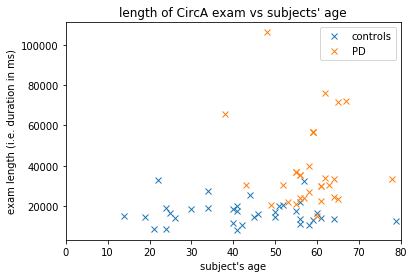

In [270]:
plt.title("length of CircA exam vs subjects' age")
plt.plot(subject_ages[31:],lengths[0][31:],'x',label="controls")
plt.xlabel("subject's age")
plt.xlim(0,80)
plt.ylabel("exam length (i.e. duration in ms)")
plt.plot(subject_ages[:31],lengths[0][:31],'x',label="PD")
plt.legend()

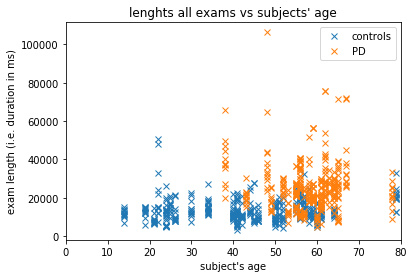

In [263]:
plt.title("lenghts all exams vs subjects' age")
plt.plot(flat_ages[31*12:],flat_lengths[31*12:],'x',label="controls")
plt.xlabel("subject's age")
plt.xlim(0,80)
plt.ylabel("exam length (i.e. duration in ms)")
plt.plot(flat_ages[0:31*12],flat_lengths[0:31*12],'x',label="PD")
plt.legend()

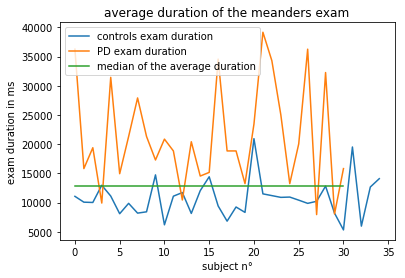

In [279]:
plt.title("average duration of the meanders exam".format(task))
plt.plot(np.mean(meanders_lengths,axis=0)[31:],label="controls exam duration")
plt.plot(np.mean(meanders_lengths,axis=0)[:31],label="PD exam duration")
plt.plot([np.median(np.mean(meanders_lengths,axis=0)) for _ in range(31)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

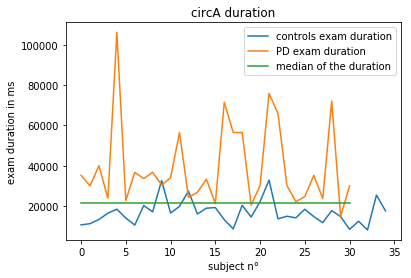

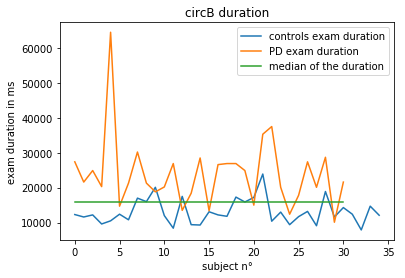

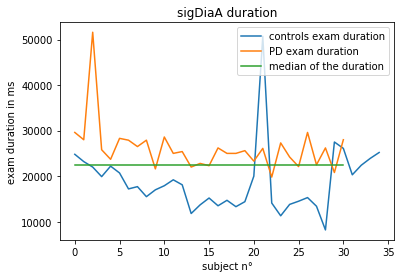

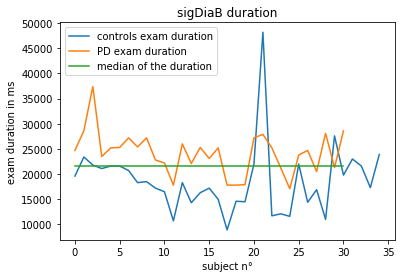

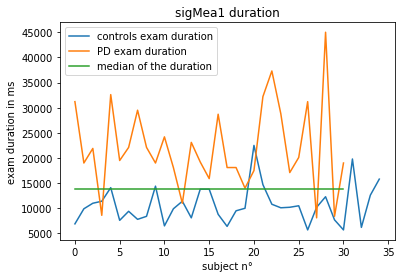

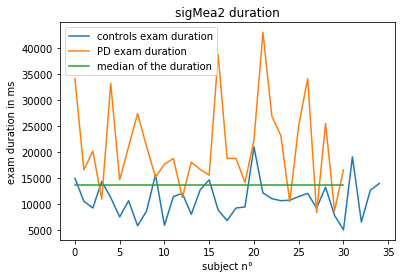

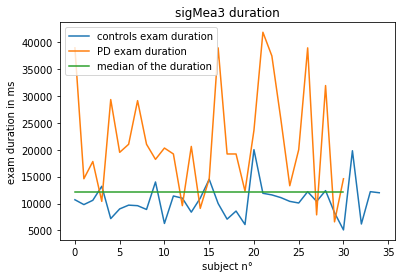

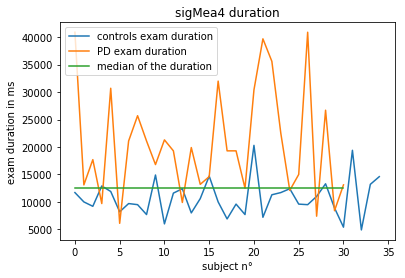

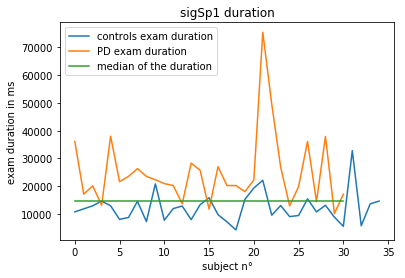

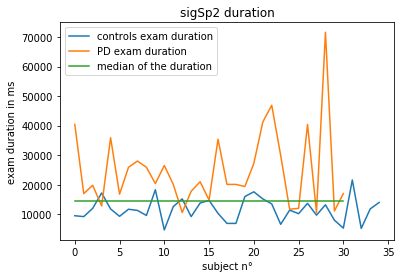

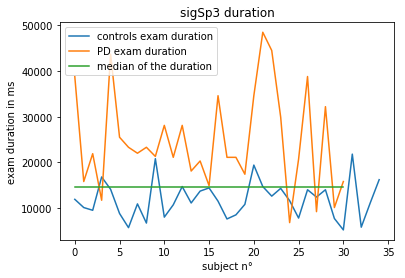

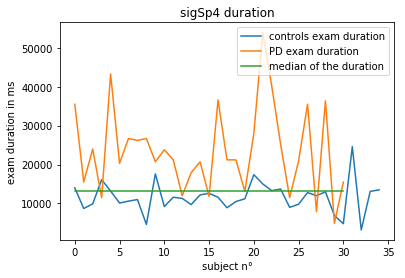

In [278]:
for i,task in enumerate(task_names):
    plt.figure()
    plt.title("{} duration".format(task))
    plt.plot(lengths[i][31:],label="controls exam duration")
    plt.plot(lengths[i][:31],label="PD exam duration")
    plt.plot([np.median(lengths[i]) for _ in range(31)],label="median of the duration")
    plt.xlabel("subject n°")
    plt.ylabel("exam duration in ms")
    plt.legend()

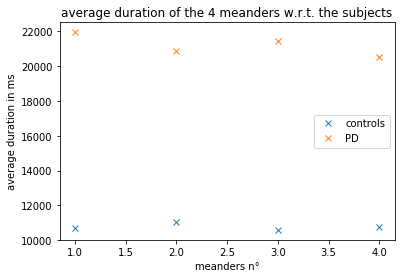

In [377]:
plt.title("average duration of the 4 meanders w.r.t. the subjects")
plt.ylabel("average duration in ms")
plt.plot([1,2,3,4],np.mean(np.asarray(meanders_lengths)[:,31:],axis=1),'x',label="controls")
plt.plot([1,2,3,4],np.mean(np.asarray(meanders_lengths)[:,:31],axis=1),'x',label="PD")
plt.xlabel("meanders n°")
plt.legend()

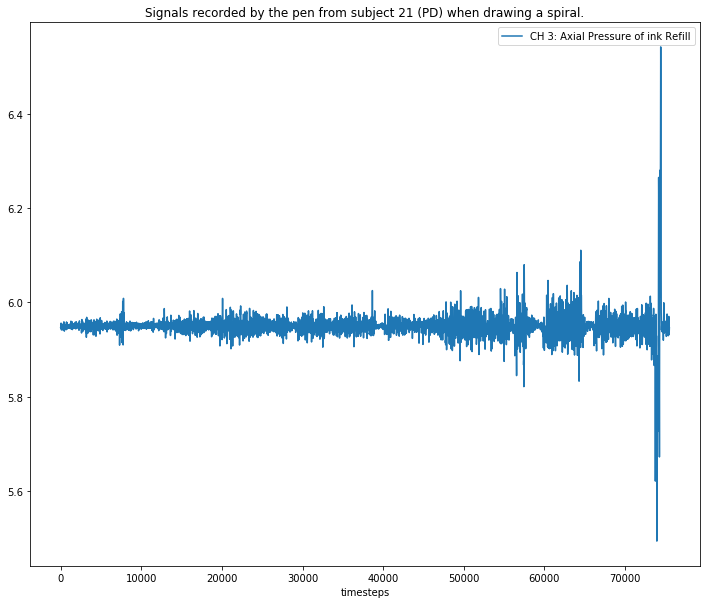

In [88]:
index=np.random.randint(0,len(data))
plt.figure(figsize=(12,10))
pd_control="PD" if targets[index] == 1 else "Control"
plt.title("Signals recorded by the pen from subject {} ({}) when drawing a spiral.".format(index,pd_control))
plt.xlabel("timesteps")
for i in [2]:
    plt.plot(data[index][:,i],label=index2measure[i])
    plt.legend()

Text(0.5,1,'Tilt and Acceleration in X VS Y direction')

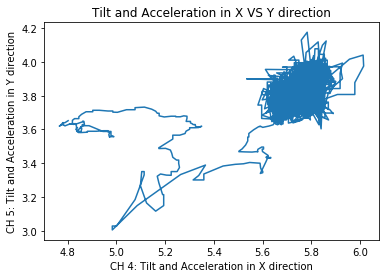

In [54]:
plt.plot(task[:,3],task[:,4])
plt.xlabel(index2measure[3])
plt.ylabel(index2measure[4])
plt.title("Tilt and Acceleration in X VS Y direction")